In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

USE_CUDA = False
SHOW_ATTENTION = True

In [3]:
from nalgene.generate import *

parsed = parse_file('.', 'grammar.nlg')
parsed.map_leaves(tokenizeLeaf)

In [4]:
import torch
from torchtext.vocab import load_word_vectors

def tokenize_sentence(s):
    s = s.lower()
    s = re.sub(r'(\d)', r'\1 ', s)
    s = re.sub(r'[^a-z0-9 \']', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s.split(' ')

class GloVeLang:
    def __init__(self, size):
        self.size = size
        base_dir = '../pytorch-seq2seq-intent-parsing/data/'
        glove_dict, glove_arr, glove_size = load_word_vectors(base_dir, 'glove.twitter.27B', size)
        self.glove_dict = glove_dict
        self.glove_arr = glove_arr

    def __str__(self):
        return "%s(size = %d)" % (self.__class__.__name__, self.size)

    def vector_from_word(self, word):
        if word in self.glove_dict:
            return self.glove_arr[self.glove_dict[word]]
        else:
            return torch.zeros(self.size)

    def tokens_to_tensor(self, words):
        tensor = torch.zeros(len(words), 1, self.size)
        for wi in range(len(words)):
            word = words[wi]
            tensor[wi][0] = self.vector_from_word(word)
        return tensor

input_lang = GloVeLang(100)

loading word vectors from ../pytorch-seq2seq-intent-parsing/data/glove.twitter.27B.100d.pt


In [5]:
def descend(node, fn, child_type='phrase', returns=None):
    if returns is None: returns = []
    returned = fn(node)
    returns.append(returned)

    for child in node.children:
        if (child_type is None) or (child.type == child_type):
            descend(child, fn, child_type, returns)
    
    return returns

In [6]:
def ascend(node, fn):
    if node.parent is None:
        return fn(node)
    else:
        return ascend(node.parent, fn)

## Building input and output vocabularies

To find all input vocabulary tokens, we can traverse the parsed nalgene tree and copy all `word` type tokens.

**TODO**: Use GloVe vectors for input vocabulary

In [7]:
# input_tokens = []

# def get_input_tokens(node):
#     if node.type == 'word':
#         input_tokens.append(node.key)

# descend(parsed, get_input_tokens, None)

# input_tokens = list(set(input_tokens))
# input_tokens = ['EOS'] + input_tokens
# print(input_tokens)

For output tokens, we can just take the top level node names that are either phrases or variables.

In [8]:
output_tokens = [child.key for child in parsed.children if child.type in ['phrase', 'ref', 'value']]
output_tokens = ['EOS'] + output_tokens
print(output_tokens)

['EOS', '%', '%main', '%if', '%timer', '%alarm', '%reminder', '%sequence', '%time', '%relative_time', '%absolute_time', '%condition', '%compare', '%getValue', '%action', '%alert', '%message', '%message_type', '@sms', '@email', '@call', '@chat', '%getLightState', '%getSwitchState', '%getTemperature', '%getPrice', '%setLightState', '%setSwitchState', '%setTemperature', '%setVolume', '%playMusic', '%greeting', '%thanks', '$message', '%operator', '@equal', '@greater_than', '@less_than', '%asset', '@btc', '@eth', '$stock', '%room_name', '@office', '@living_room', '@bedroom', '@basement', '@kitchen', '@bathroom', '@outside', '%light_name', '@office_light', '@living_room_light', '@bedroom_light', '@basement_light', '@kitchen_light', '@bathroom_light', '@outside_light', '%switch_name', '@tea_switch', '@coffee_switch', '%light_state', '%switch_state', '%volume_state', '@on', '@off', '@up', '@down', '@high', '@low', '$color', '$number', '$digits', '$digit', '%time_unit', '@seconds', '@minutes', 

## Getting input and target data for nodes

In [9]:
def words_for_position(words, position):
    if position is None:
        return words
    start, end, length = position
    return words[start : end + 1]

In [10]:
def relative_position(node, parent):
    if parent.position is None:
        return node.position
    return node.position[0] - parent.position[0], node.position[1] - parent.position[0], node.position[2]

In [11]:
def data_for_node(flat, node):
    words = [child.key for child in flat.children]
    inputs = words_for_position(words, node.position)
    keys = [child.key for child in node.children]
    positions = [relative_position(child, node) for child in node.children]
    return node.key, inputs, list(zip(keys, positions))

## Creating tensors for input and target data

In [12]:
def tokens_to_tensor(tokens, source_tokens, append_eos=True):
    indexes = []
    for token in tokens:
        indexes.append(source_tokens.index(token))
    if append_eos:
        indexes.append(0)
    return torch.LongTensor(indexes)

In [13]:
def ranges_to_tensor(ranges, seq_len):
    ranges_tensor = torch.zeros(len(ranges), seq_len)
    for r in range(len(ranges)):
        start, end, _ = ranges[r]
        ranges_tensor[r, start:end+1] = 1
    return ranges_tensor

## Model

The core model is a regular seq2seq/encoder-decoder model with attention. The attention model is from [Luong et al.'s "Effective Approaches to Attention-based Neural Machine Translation"](https://arxiv.org/abs/1508.04025) using dot-product based attention energies, with one important difference: there is no softmax layer, allowing attention to focus on multiple tokens at once. Instead a sigmoid layer is added to squeeze outputs between 0 and 1.

The encoder and decoder take one additional input `context` which represents the type of phrase, e.g. `%setLightState`. At the top level node the context is always `%`.

The encoder encodes the input sequence into a series of vectors using a bidirectional GRU. The decoder "translates" this into a sequence of phrase tokens, given the encoder outputs and current context, e.g. "turn off the office light" + `%setLightState` &rarr; `[$on_off, $light]`.

Once the decoder has chosen tokens and alignments, the phrase tokens and selection of inputs are used as the context and inputs of the next iteration. This recurs until no more phrase tokens are found.

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.05):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout, bidirectional=True)

    def forward(self, context_input, word_inputs):
        # TODO: Incorporate context input
        # TODO: Batching
        
        seq_len = word_inputs.size(0)
        batch_size = word_inputs.size(1)
        
        embedded = self.embedding(word_inputs.view(seq_len * batch_size, -1)) # Process seq x batch at once
        output = embedded.view(seq_len, batch_size, -1) # Resize back to seq x batch for RNN

        outputs, hidden = self.gru(output)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs

        return outputs, hidden

In [15]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attention_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attention_energies = attention_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attention_energies[i] = hidden.dot(encoder_outputs[i])

        # Squeeze to range 0 to 1, resize to 1 x 1 x seq_len
        return F.sigmoid(attention_energies).unsqueeze(0).unsqueeze(0)

In [16]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout=0.05):
        super(Decoder, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Attention module
        self.attention = Attention()
    
    def forward(self, context_input, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: Batching
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine context and embedded word, through RNN
        rnn_input = torch.cat((context_input.unsqueeze(0), word_embedded), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attention_weights = self.attention(rnn_output.squeeze(0), encoder_outputs)
        context = attention_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attention_weights

We can turn the whole thing into one module by combining the Encoder and Decoder networks. There's also an embedding layer for the context tokens.

In [17]:
MAX_LENGTH = 50

class RARNN(nn.Module):
    def __init__(self, input_size, output_tokens, hidden_size):
        super(RARNN, self).__init__()
        
        self.output_tokens = output_tokens
        self.input_size = input_size
        self.output_size = len(output_tokens)
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(self.output_size, hidden_size)
        
        self.encoder = Encoder(self.input_size, hidden_size)
        self.decoder = Decoder(hidden_size, self.output_size)

    def forward(self, context_input, word_inputs, word_targets=None):
        # Get embedding for context input
        context_embedded = self.embedding(context_input)
        
        input_len = word_inputs.size(0)
        target_len = word_targets.size(0) if word_targets is not None else MAX_LENGTH
        
        # Run through encoder
        encoder_outputs, encoder_hidden = self.encoder(context_embedded, word_inputs)
        decoder_hidden = encoder_hidden # Use encoder's last hidden state
        decoder_input = Variable(torch.LongTensor([0])) # EOS/SOS token
        if USE_CUDA:
            decoder_input = decoder_input.cuda()

        # Variables to store decoder and attention outputs
        decoder_outputs = Variable(torch.zeros(target_len, self.output_size))
        decoder_attentions = Variable(torch.zeros(target_len, input_len))
        if USE_CUDA:
            decoder_outputs = decoder_outputs.cuda()
            decoder_attentions = decoder_attentions.cuda()
        
        # Run through decoder
        for i in range(target_len):
            decoder_output, decoder_hidden, decoder_attention = self.decoder(context_embedded, decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[i] = decoder_output
            decoder_attentions[i] = decoder_attention

            # Teacher forcing with known targets, if provided
            if word_targets is not None:
                decoder_input = word_targets[i]

            # Sample with last outputs
            else:
                max_index = decoder_output.topk(1)[1].data[0][0]
                decoder_input = Variable(torch.LongTensor([max_index]))
                if USE_CUDA:
                    decoder_input = decoder_input.cuda()

                if max_index == 0: break # EOS
        
        # Slice outputs
        if word_targets is None:
            if i > 0:
                decoder_outputs = decoder_outputs[:i]
                decoder_attentions = decoder_attentions[:i]
            else:
                decoder_outputs = Variable(torch.Tensor())
                decoder_attentions = Variable(torch.Tensor())

        elif target_len > 1:
            decoder_attentions = decoder_attentions[:-1] # Ignore attentions on EOS

        return decoder_outputs, decoder_attentions

## Training

The inputs to the network are the current phrase label, e.g. `%getLightState` and the string to parse, "the living room light is on". The outputs are the child node labels, `$light` and `$on_off` with a selection of words given by attention-like weights over the sequence, treated as boolean values given a threshold.

In [18]:
input_size = 100
hidden_size = 100

learning_rate = 1e-4
weight_decay = 1e-6

rarnn = RARNN(input_size, output_tokens, hidden_size)
optimizer = torch.optim.Adam(rarnn.parameters(), lr=learning_rate, weight_decay=weight_decay)

decoder_criterion = nn.NLLLoss()
attention_criterion = nn.MSELoss(size_average=False)

In [19]:
def train(flat, node):
    context, inputs, targets = data_for_node(flat, node)

    # Turn inputs into tensors
    context_var = tokens_to_tensor([context], rarnn.output_tokens, False)
    context_var = Variable(context_var)
    inputs_var = input_lang.tokens_to_tensor(inputs) # seq x batch x size
    inputs_var = Variable(inputs_var)
    target_tokens = [target_token for target_token, _ in targets]
    target_ranges = [target_range for _, target_range in targets]
    target_tokens_var = tokens_to_tensor(target_tokens, rarnn.output_tokens)
    target_tokens_var = Variable(target_tokens_var)
    target_ranges_var = ranges_to_tensor(target_ranges, len(inputs))
    target_ranges_var = Variable(target_ranges_var)
 
    # Run through model
    decoder_outputs, attention_outputs = rarnn(context_var, inputs_var, target_tokens_var)

    # Loss calculation and backprop
    optimizer.zero_grad()
    decoder_loss = decoder_criterion(decoder_outputs, target_tokens_var)
    if len(targets) > 0:
        attention_loss = attention_criterion(attention_outputs, target_ranges_var)
    else:
        attention_loss = 0
    total_loss = decoder_loss + attention_loss
    total_loss.backward()
    optimizer.step()

    return total_loss.data[0]

In [20]:
import sconce
job = sconce.Job('rarnn')
job.plot_every = 20
job.log_every = 100

n_epochs = 5000

for i in range(n_epochs):
    walked_flat, walked_tree = walk_tree(parsed, parsed['%'], None)
    def _train(node): return train(walked_flat, node)
    ds = descend(walked_tree, _train)
    d = sum(ds) / len(ds)
    job.record(i, d)

Starting job 5945d97ef8e1c2083c22e0b1 at 2017-06-17 18:38:06
[log] 0m 8s (100) 4.3188
[log] 0m 18s (200) 1.0373
[log] 0m 27s (300) 0.7562
[log] 0m 35s (400) 3.1305
[log] 0m 45s (500) 0.3602
[log] 0m 54s (600) 0.4813
[log] 1m 5s (700) 0.3830
[log] 1m 14s (800) 0.1757
[log] 1m 25s (900) 1.9926
[log] 1m 35s (1000) 1.6087
[log] 1m 46s (1100) 0.1349
[log] 1m 54s (1200) 0.1791
[log] 2m 4s (1300) 0.0779
[log] 2m 16s (1400) 0.1250
[log] 2m 27s (1500) 0.1004
[log] 2m 38s (1600) 0.0730
[log] 2m 49s (1700) 0.0762
[log] 2m 59s (1800) 0.0403
[log] 3m 10s (1900) 0.0182
[log] 3m 22s (2000) 0.0059
[log] 3m 34s (2100) 0.0430
[log] 3m 45s (2200) 0.0731
[log] 3m 55s (2300) 0.0526
[log] 4m 4s (2400) 0.0451
[log] 4m 14s (2500) 0.0235
[log] 4m 22s (2600) 0.0061
[log] 4m 33s (2700) 0.3634
[log] 4m 45s (2800) 0.2099
[log] 4m 55s (2900) 0.0206
[log] 5m 6s (3000) 0.0111
[log] 5m 15s (3100) 0.0018
[log] 5m 26s (3200) 0.4094
[log] 5m 40s (3300) 0.5237
[log] 5m 49s (3400) 0.0044
[log] 6m 1s (3500) 0.0179
[log] 6m 

## Evaluating

In [21]:
def evaluate(context, inputs, node=None):
    if node == None:
        node = Node('parsed')
        node.position = (0, len(inputs))
    
    # Turn data into tensors
    context_var = tokens_to_tensor([context], rarnn.output_tokens, False)
    context_var = Variable(context_var)
    inputs_var = input_lang.tokens_to_tensor(inputs) # seq x batch x size
    inputs_var = Variable(inputs_var)
    
    # Run through RARNN
    decoder_outputs, attention_outputs = rarnn(context_var, inputs_var)
    
    # Given the decoder and attention outputs, gather contexts and inputs for sub-phrases
    # Use attention values > 0.5 to select words for next input sequence

    next_contexts = []
    next_inputs = []
    next_positions = []
    
    for i in range(len(decoder_outputs)):
        max_value, max_index = decoder_outputs[i].topk(1)
        max_index = max_index.data[0]
        next_contexts.append(rarnn.output_tokens[max_index]) # Get decoder output token
        a = attention_outputs[i]
        next_input = []
        next_position = []
        for t in range(len(a)):
            at = a[t].data[0]
            if at > 0.5:
                if len(next_position) == 0: # Start position
                    next_position.append(t)
                next_input.append(inputs[t])
            else:
                if len(next_position) == 1: # End position
                    next_position.append(t - 1)
        if len(next_position) == 1: # End position
            next_position.append(t)
        next_inputs.append(next_input)
        if len(next_position) == 2:
            next_position = (next_position[0] + node.position[0], next_position[1] + node.position[0])
        next_positions.append(next_position)

    evaluated = list(zip(next_contexts, next_inputs, next_positions))

    # Print decoded outputs
    print('\n(evaluate) %s %s -> %s' % (context, ' '.join(inputs), next_contexts))
    
    # Plot attention outputs
    if SHOW_ATTENTION:
        if len(attention_outputs) > 1:
            print(attention_outputs)
            fig = plt.figure(figsize=(len(inputs) / 3, 99))
            sub = fig.add_subplot(111)
            sub.matshow(attention_outputs.data.squeeze(1).numpy(), vmin=0, vmax=1, cmap='hot')
            plt.show(); plt.close()
        else:
            print("WARNING: No attention outputs")
    
    for context, inputs, position in evaluated:
        # Add a node for parsed sub-phrases and values
        sub_node = Node(context)
        sub_node.position = position
        node.add(sub_node)
        
        # Recursively evaluate sub-phrases
        if context[0] == '%':
            if len(inputs) > 0:
                evaluate(context, inputs, sub_node)
            else:
                print("WARNING: Empty inputs")
    
        # Or add words directly to value node
        elif context[0] == '$':
            sub_node.add(' '.join(inputs))

    return node

In [22]:
def evaluate_and_print(context, inputs):
    evaluated = evaluate(context, inputs)
    print(' '.join(inputs))
    print(evaluated)
    return evaluated

In [23]:
evaluate_and_print('%', "hey maia what's the btc price".split(' '))


(evaluate) % hey maia what's the btc price -> ['%sequence']

(evaluate) %sequence maia what's the btc price -> ['%action']

(evaluate) %action maia what's the btc price -> ['%getPrice']

(evaluate) %getPrice maia what's the btc price -> ['%asset']

(evaluate) %asset maia btc -> ['@btc']
hey maia what's the btc price
( parsed (0, 6)
    ( %sequence (1, 5)
        ( %action (1, 5)
            ( %getPrice (1, 5)
                ( %asset (1, 1)
                    ( @btc (1, 2) ) ) ) ) ) )



(evaluate) % plz call me when the price of tesla is above 5 0 -> ['%if']

(evaluate) %if plz call me when the price of tesla is above 5 0 -> ['%alert', '%condition']
Variable containing:

Columns 0 to 9 
 0.9992  0.9949  0.9812  0.0012  0.0730  0.0121  0.0106  0.0107  0.0003  0.0030
 0.0038  0.0185  0.0439  0.0057  0.9385  0.9858  0.9972  0.9987  0.9992  0.9999

Columns 10 to 11 
 0.0107  0.0043
 0.9996  0.9996
[torch.FloatTensor of size 2x12]



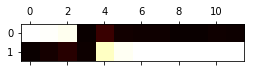


(evaluate) %alert plz call me -> ['%message_type']

(evaluate) %message_type call -> ['@call']

(evaluate) %condition the price of tesla is above 5 0 -> ['%getValue', '$number']
Variable containing:
 0.9993  0.9997  0.9956  0.9776  0.1356  0.2025  0.0101  0.0017
 0.0001  0.0009  0.0021  0.0003  0.0313  0.9805  0.7363  0.7212
[torch.FloatTensor of size 2x8]



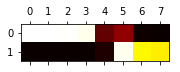


(evaluate) %getValue the price of tesla -> ['%getPrice']

(evaluate) %getPrice the price of tesla -> ['%asset']

(evaluate) %asset tesla -> ['$stock']
plz call me when the price of tesla is above 5 0
( parsed (0, 12)
    ( %if (0, 11)
        ( %alert (0, 2)
            ( %message_type (1, 1)
                ( @call (1, 1) ) ) )
        ( %condition (4, 11)
            ( %getValue (4, 7)
                ( %getPrice (4, 7)
                    ( %asset (7, 7)
                        ( $stock (7, 7) tesla ) ) ) )
            ( $number (9, 11) above 5 0 ) ) ) )


In [24]:
evaluate_and_print('%', "plz call me when the price of tesla is above 5 0".split(' '))


(evaluate) % hey maia if the ethereum price is less than 2 0 then turn the living room light on -> ['%if']

(evaluate) %if if the ethereum price is less than 2 0 then turn the living room light on -> ['%condition', '%sequence']
Variable containing:

Columns 0 to 5 
 5.2703e-02  9.8708e-01  9.9661e-01  9.3996e-01  9.6085e-01  9.9436e-01
 1.7502e-04  6.1326e-02  4.3590e-04  4.6715e-04  2.5827e-04  6.9270e-04

Columns 6 to 11 
 8.5065e-01  9.8593e-01  9.4292e-01  5.1305e-03  1.3066e-03  8.0447e-03
 2.4266e-03  1.3568e-02  2.9568e-02  2.8469e-01  9.8339e-01  9.9992e-01

Columns 12 to 15 
 1.4485e-02  1.6154e-03  1.0330e-03  8.6225e-06
 9.9836e-01  9.9762e-01  9.9991e-01  9.9941e-01
[torch.FloatTensor of size 2x16]



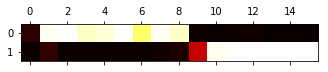


(evaluate) %condition the ethereum price is less than 2 0 -> ['%getValue', '%operator', '$number']
Variable containing:

Columns 0 to 5 
 9.9964e-01  9.9971e-01  9.9871e-01  2.6355e-01  6.1660e-02  3.3172e-04
 4.6563e-04  1.4216e-03  6.4425e-03  2.2843e-02  9.9206e-01  9.7696e-01
 1.9768e-06  6.3569e-05  1.1907e-07  1.0644e-05  1.5179e-02  5.6186e-02

Columns 6 to 7 
 1.3233e-04  4.0747e-05
 2.3411e-01  2.4424e-01
 9.6682e-01  9.9454e-01
[torch.FloatTensor of size 3x8]



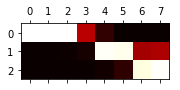


(evaluate) %getValue the ethereum price -> ['%getPrice']

(evaluate) %getPrice the ethereum price -> ['%asset']

(evaluate) %asset ethereum -> ['@eth']

(evaluate) %operator less than -> ['@less_than']

(evaluate) %sequence turn the living room light on -> ['%action']

(evaluate) %action turn the living room light on -> ['%setLightState']

(evaluate) %setLightState turn the living room light on -> ['%light_name', '%light_state']
Variable containing:
 0.1356  0.9793  0.9996  0.9991  0.9432  0.0341
 0.0001  0.0113  0.0103  0.0076  0.0320  0.9834
[torch.FloatTensor of size 2x6]



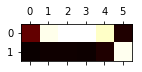


(evaluate) %light_name the living room light -> ['@living_room_light']

(evaluate) %light_state on -> ['@on']
hey maia if the ethereum price is less than 2 0 then turn the living room light on
( parsed (0, 18)
    ( %if (2, 17)
        ( %condition (3, 10)
            ( %getValue (3, 5)
                ( %getPrice (3, 5)
                    ( %asset (4, 4)
                        ( @eth (4, 4) ) ) ) )
            ( %operator (7, 8)
                ( @less_than (7, 8) ) )
            ( $number (9, 10) 2 0 ) )
        ( %sequence (12, 17)
            ( %action (12, 17)
                ( %setLightState (12, 17)
                    ( %light_name (13, 16)
                        ( @living_room_light (13, 16) ) )
                    ( %light_state (17, 17)
                        ( @on (17, 17) ) ) ) ) ) ) )

(evaluate) % hey maia what's the ethereum price -> ['%sequence']

(evaluate) %sequence maia what's the ethereum price -> ['%action']

(evaluate) %action maia what's the ethereum price 

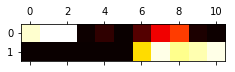


(evaluate) %action play some Skrillex -> ['%playMusic']

(evaluate) %playMusic play some Skrillex -> ['$artist_name']

(evaluate) %action turn the office light off -> ['%setLightState']

(evaluate) %setLightState turn the office light off -> ['%light_name', '%light_state']
Variable containing:
 0.1775  0.9770  0.9984  0.9725  0.1154
 0.0001  0.0119  0.0117  0.0799  0.9750
[torch.FloatTensor of size 2x5]



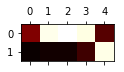


(evaluate) %light_name the office light -> ['@office_light']

(evaluate) %light_state off -> ['@off']
hey maia play some Skrillex please and then turn the office light off
( parsed (0, 13)
    ( %sequence (2, 12)
        ( %action (2, 4)
            ( %playMusic (2, 4)
                ( $artist_name (4, 4) Skrillex ) ) )
        ( %action (8, 12)
            ( %setLightState (8, 12)
                ( %light_name (9, 11)
                    ( @office_light (9, 11) ) )
                ( %light_state (12, 12)
                    ( @off (12, 12) ) ) ) ) ) )

(evaluate) % turn the office light up and also could you please turn off the living room light and make the temperature of the bedroom to 6 thank you maia -> ['%sequence']

(evaluate) %sequence turn the office light up and also could you please turn off the living room light and make the temperature of the bedroom to 6 -> ['%action', '%action', '%action']
Variable containing:

Columns 0 to 5 
 9.9543e-01  9.9931e-01  9.9962e-01  9.983

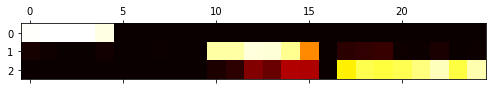


(evaluate) %action turn the office light up -> ['%setLightState']

(evaluate) %setLightState turn the office light up -> ['%light_name', '%light_state']
Variable containing:
 0.1112  0.9599  0.9965  0.9061  0.0086
 0.0001  0.0106  0.0106  0.0683  0.9011
[torch.FloatTensor of size 2x5]



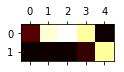


(evaluate) %light_name the office light -> ['@office_light']

(evaluate) %light_state up -> ['@up']

(evaluate) %action turn off the living room light -> ['%setLightState']

(evaluate) %setLightState turn off the living room light -> ['%light_name', '%light_state']
Variable containing:
 0.2023  0.8455  0.1936  0.8200  0.6191  0.0178
 0.0001  0.0816  0.0250  0.0229  0.0279  0.2038
[torch.FloatTensor of size 2x6]



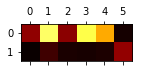


(evaluate) %light_name off living room -> ['@living_room_light']

(evaluate) %action make the temperature of the bedroom to 6 -> ['%setTemperature']

(evaluate) %setTemperature make the temperature of the bedroom to 6 -> ['%room_name', '$temperature']
Variable containing:

Columns 0 to 5 
 1.5998e-03  1.1430e-02  1.4474e-03  4.3956e-03  6.1450e-02  9.8775e-01
 7.2643e-07  5.2093e-06  4.0760e-06  6.0852e-06  7.2367e-05  6.5544e-04

Columns 6 to 7 
 2.9442e-03  6.1333e-02
 2.0923e-02  9.8676e-01
[torch.FloatTensor of size 2x8]



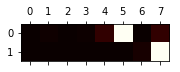


(evaluate) %room_name bedroom -> ['@bathroom']
turn the office light up and also could you please turn off the living room light and make the temperature of the bedroom to 6 thank you maia
( parsed (0, 28)
    ( %sequence (0, 24)
        ( %action (0, 4)
            ( %setLightState (0, 4)
                ( %light_name (1, 3)
                    ( @office_light (1, 3) ) )
                ( %light_state (4, 4)
                    ( @up (4, 4) ) ) ) )
        ( %action (10, 15)
            ( %setLightState (10, 15)
                ( %light_name (11, 11)
                    ( @living_room_light (11, 13) ) )
                ( %light_state [] ) ) )
        ( %action (17, 24)
            ( %setTemperature (17, 24)
                ( %room_name (22, 22)
                    ( @bathroom (22, 22) ) )
                ( $temperature (24, 24) 6 ) ) ) ) )

(evaluate) % turn the living room light off and turn the bedroom light up and also turn the volume up -> ['%setLightState']

(evaluate) %setLight

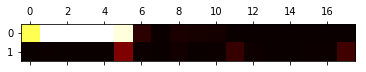


(evaluate) %light_name turn the living room light off -> ['@living_room_light']
turn the living room light off and turn the bedroom light up and also turn the volume up
( parsed (0, 18)
    ( %setLightState (0, 17)
        ( %light_name (0, 5)
            ( @living_room_light (0, 5) ) )
        ( %light_state [] ) ) )


In [25]:
evaluate_and_print('%', "hey maia if the ethereum price is less than 2 0 then turn the living room light on".split(' '))
evaluate_and_print('%', "hey maia what's the ethereum price".split(' '))
evaluate_and_print('%', "hey maia play some Skrillex please and then turn the office light off".split(' '))
evaluate_and_print('%', "turn the office light up and also could you please turn off the living room light and make the temperature of the bedroom to 6 thank you maia".split(' '))
evaluate_and_print('%', "turn the living room light off and turn the bedroom light up and also turn the volume up".split(' '))

words ['heya', 'shoot', 'me', 'an', 'email', 'if', 'the', 'price', 'of', 'bitcoin', 'is', 'bigger', 'than', '3', '0', '0', '0', 'would', 'ya']

(evaluate) % heya shoot me an email if the price of bitcoin is bigger than 3 0 0 0 would ya -> ['%if']

(evaluate) %if shoot me an email if the price of bitcoin is bigger than 3 0 0 0 -> ['%alert', '%condition']
Variable containing:

Columns 0 to 9 
 0.9998  0.9988  0.8995  0.9537  0.0081  0.2099  0.0483  0.0483  0.0197  0.0019
 0.0008  0.0010  0.0001  0.0120  0.0746  0.9887  0.9968  0.9992  0.9989  0.9993

Columns 10 to 15 
 0.0091  0.0016  0.0103  0.0037  0.0014  0.0007
 0.9991  0.9975  0.9996  0.9993  0.9990  0.9987
[torch.FloatTensor of size 2x16]



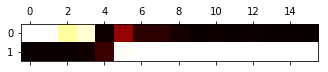


(evaluate) %alert shoot me an email -> ['%message_type']

(evaluate) %message_type email -> ['@email']

(evaluate) %condition the price of bitcoin is bigger than 3 0 0 0 -> ['%getValue', '%operator', '$number']
Variable containing:

Columns 0 to 5 
 9.9992e-01  9.9996e-01  9.9954e-01  9.9435e-01  1.0395e-01  1.7570e-02
 2.0009e-04  2.4964e-03  1.0730e-02  8.7231e-03  2.3112e-02  9.8321e-01
 3.6184e-07  2.1461e-08  1.5177e-06  7.3842e-06  1.5524e-05  7.0941e-04

Columns 6 to 10 
 8.0400e-04  3.7924e-04  1.7648e-04  5.0516e-05  1.0655e-05
 9.8296e-01  1.7921e-01  1.6781e-01  1.9078e-01  1.9987e-01
 3.0326e-02  9.3317e-01  9.9116e-01  9.9779e-01  9.9905e-01
[torch.FloatTensor of size 3x11]



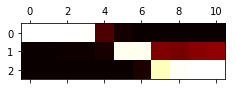


(evaluate) %getValue the price of bitcoin -> ['%getPrice']

(evaluate) %getPrice the price of bitcoin -> ['%asset']

(evaluate) %asset bitcoin -> ['@btc']

(evaluate) %operator bigger than -> ['@greater_than']
heya shoot me an email if the price of bitcoin is bigger than 3 0 0 0 would ya
( parsed (0, 19)
    ( %if (1, 16)
        ( %alert (1, 4)
            ( %message_type (4, 4)
                ( @email (4, 4) ) ) )
        ( %condition (6, 16)
            ( %getValue (6, 9)
                ( %getPrice (6, 9)
                    ( %asset (9, 9)
                        ( @btc (9, 9) ) ) ) )
            ( %operator (11, 12)
                ( @greater_than (11, 12) ) )
            ( $number (13, 16) 3 0 0 0 ) ) ) )
response {'parsed': {'key': 'parsed', 'position': (0, 19), 'children': [{'key': '%if', 'position': (1, 16), 'children': [{'key': '%alert', 'position': (1, 4), 'children': [{'key': '%message_type', 'position': (4, 4), 'children': [{'key': '@email', 'position': (4, 4), 'childre

In [26]:
def parse(s, cb):
    words = tokenize_sentence(s)
    print('words', words)
    try:
        evaluated = evaluate_and_print('%', words)
        cb({'words': words, 'parsed': evaluated.to_json()})
    except Exception:
        cb({'error': "Failed to evaluate"})

parse('heya shoot me an email if the price of bitcoin is bigger than 3 0 0 0 would ya', lambda r: print("response", r))

In [27]:
import somata
service = somata.Service('maia:parser', {'parse': parse}, {'bind_port': 8855})

ZMQError: Address already in use

In [ ]:
service.socket.close()